# Sementaic segmentation
- 이미지에서 도로를 segmentation하기

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import os.path as osp
import PIL

torch.manual_seed(0)




- Training data

![source](./data/Kitti/data_road/training/image_2/um_000081.png "Variable")  
./data/Kitti/data_road/training/image_2/um_000081.png (source)

![target](./data/Kitti/data_road/training/gt_image_2/um_road_000081.png "Variable")  
./data/Kitti/data_road/training/gt_image_2/um_road_000081.png (target)


# Dataloader

- 데이터셋 목록 확인하기

In [2]:
# check list of train data
imgsets_file = osp.join('data/Kitti', 'train.txt')

for i, src_tar_name in enumerate(open(imgsets_file)):
    src_tar_name = src_tar_name.split()
    print('%d :' % i, src_tar_name)
    if i > 3:
        break


0 : ['training/image_2/um_000000.png', 'training/gt_image_2/um_road_000000.png']
1 : ['training/image_2/um_000001.png', 'training/gt_image_2/um_road_000001.png']
2 : ['training/image_2/um_000002.png', 'training/gt_image_2/um_road_000002.png']
3 : ['training/image_2/um_000003.png', 'training/gt_image_2/um_road_000003.png']
4 : ['training/image_2/um_000004.png', 'training/gt_image_2/um_road_000004.png']


- 데이터 셋 클래스

In [ ]:
class KITTIdataset(torch.utils.data.Dataset):
    class_names = np.array(['background', 'road'])
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    # root <- "./resources"
    def __init__(self, root, split='train', transform=False):
        self._transform = transform
        dataset_dir = osp.join(root, 'Kitti')
        self.files = [] 

        # Append file paths in the list
        imgsets_file = os.path.join(dataset_dir, '%s.txt'% split)
        for i, src_tar_name in enumerate(open(imgsets_file)):
            src_tar_name = src_tar_name.strip()
            src_tar_name = src_tar_name.split()
            # save file names in a list of dictionary format
            self.files.append({"img" : os.path.join(dataset_dir, "data_road", src_tar_name[0]), "lbl" : os.path.join(dataset_dir, "data_road",src_tar_name[1]) })
        
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        # load image & label
        # TODO
        # image -> img, label -> lbl
        data_file = self.files[index]
        img_file = data_file["img"]
        lbl_file = data_file["lbl"]
        
        
        img = PIL.Image.open(img_file)
        img = np.array(img, dtype=np.uint8)
        lbl = PIL.Image.open(lbl_file)
        lbl = np.array(lbl, dtype=np.int32)
        lbl[lbl == 255] = 1
        
        img, lbl = self.transform(img, lbl)
        return img, lbl

    def transform(self, img, lbl):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean_bgr
        img = img.transpose(2, 0, 1) # H W C -> C H W
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl

In [9]:
train_loader = torch.utils.data.DataLoader(KITTIdataset(root = './data', split = 'train', transform = True), 
                                           batch_size = 1, shuffle = True)

val_loader = torch.utils.data.DataLoader(KITTIdataset(root = './data', split = 'val', transform = True), 
                                         batch_size = 1, shuffle = False)

vgg16 = torchvision.models.vgg16(pretrained = True)

for data in train_loader:
    print(data[0].shape, data[1].shape)
    break

torch.Size([1, 3, 370, 1226]) torch.Size([1, 370, 1226])


# Define the Network

- FCN model

<img src="resources/fcn_upsampling.png" width="60%">

In [10]:
class FCN(nn.Module):
    def __init__(self, num_class = 21):
        super(FCN, self).__init__()
        
        ## Why padding 100?? https://github.com/shelhamer/fcn.berkeleyvision.org
        self.features1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding = 100),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(inplace = True))
    
        self.features2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.ReLU(inplace = True))
        
        self.features3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1))
        
        self.features4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1))
                
        self.features5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1))
        
        self.maxpool = nn.MaxPool2d(2, stride = 2, ceil_mode = True)

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace = True),
            nn.Dropout2d(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace = True),
            nn.Dropout2d(),
            nn.Conv2d(4096, num_class, 1))
        
        self.upscore2 = nn.ConvTranspose2d(num_class, num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore4 = nn.ConvTranspose2d(num_class, num_class, kernel_size = 4, stride = 2, bias = False)
        self.upscore8 = nn.ConvTranspose2d(num_class, num_class, kernel_size = 16, stride = 8, bias = False)
        
        self.score_pool4 = nn.Conv2d(512, num_class, 1)
        self.score_pool3 = nn.Conv2d(256, num_class, 1)
        
        self.params = [self.features1, self.features2, self.features3, 
                       self.features4, self.features5]
        
    def upsample(self, x, size):
        return nn.functional.upsample(x, size = size, mode = 'bilinear')
                             
    def forward(self, inputs):
        x = self.features1(inputs)
        pool1 = self.maxpool(x)
        x = self.features2(pool1)
        pool2 = self.maxpool(x)
        x = self.features3(pool2)
        pool3 = self.maxpool(x)
        x = self.features4(pool3)
        pool4 = self.maxpool(x)
        x = self.features5(pool4)
        pool5 = self.maxpool(x)
        x = self.classifier(pool5)
        
        # also use getattr with for loop ...
        x = self.upscore2(x)
        
        pool4 = self.score_pool4(pool4)
        pool4 = pool4[:, :, 5:5 + x.size()[2], 5:5 + x.size()[3]]
        x = torch.add(x, pool4)
        
        x = self.upscore4(x)
        
        pool3 = self.score_pool3(pool3)
        pool3 = pool3[:, :, 9:9 + x.size()[2], 9:9 + x.size()[3]]
        x = torch.add(x, pool3)
        
        x = self.upscore8(x)
        x = x[:, :, 33:33 + inputs.size()[2], 33:33 + inputs.size()[3]]
        return x
    
    def copy_params(self, vgg):
        for l1, l2 in zip(vgg.features, self.params):
            if (isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d)):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data

# U-Net


-  U-Net model  
![unet](./resources/unet.png "Variable")

- EncoderBlock
    
    - conv2d in -> out (kernel = 3)
    - batchnorm2d
    - relu
    - conv2d out -> out (kernel = 3)
    - batchnorm2d
    - relu
    - dropout
    - maxpool (kernel = 2, sride = 2)


- DecoderBlock
    
    - conv2d in -> middle (kernel = 3)
    - batchnorm2d
    - relu
    - conv2d middle -> middle (kernel = 3)
    - batchnorm2d
    - relu
    - convtranspose2d middle -> out (kernel = 3, stride = 2) 

In [16]:

class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        # TODO
        layers = [
            nn.Conv2d(in_channels,out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        # TODO
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels,middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(middle_channels,middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(middle_channels,out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.decode(x)


class UNet(nn.Module):
    def __init__(self, num_classes, num_channels=4):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, num_channels)
        self.enc2 = _EncoderBlock(num_channels, num_channels*2)
        self.enc3 = _EncoderBlock(num_channels*2, num_channels*4)
        self.enc4 = _EncoderBlock(num_channels*4, num_channels*8, dropout=True)
        self.center = _DecoderBlock(num_channels*8, num_channels*16, num_channels*8)
        self.dec4 = _DecoderBlock(num_channels*16, num_channels*8, num_channels*4)
        self.dec3 = _DecoderBlock(num_channels*8, num_channels*4, num_channels*2)
        self.dec2 = _DecoderBlock(num_channels*4, num_channels*2, num_channels)
        self.dec1 = nn.Sequential(
            nn.Conv2d(num_channels*2, num_channels, kernel_size=3),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channels, num_channels, kernel_size=3),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(num_channels, num_classes, kernel_size=1)
        

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        return F.upsample(final, x.size()[2:], mode='bilinear')

## Visualization

In [17]:
from PIL import Image # import 
def visualization(net, image, epoch, device):
    
    if not os.path.exists('./output'):
        os.makedirs('./output')
    
    net.to('cpu')
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    img = image
    img = np.array(img, dtype = np.uint8)
    img = img[:, :, ::-1] # channel RGB -> BGR
    img = img.astype(np.float64)
    img -= mean_bgr
    img = img.transpose(2, 0, 1) # H W C -> C H W
    img = torch.from_numpy(img).float()
    img = img.unsqueeze(0)

    score = net(img)
    lbl_pred = score.data.max(1)[1].cpu().numpy()
    lbl_pred = np.squeeze(lbl_pred)

    Image.fromarray((lbl_pred * 255).astype(np.uint8)).save('./output/mask_epoch'+str(epoch+1)+'.png')
    
    input_img = image
    input_img = np.array(input_img, dtype = np.uint8)
    color = [0, 255, 0, 127] 
    color = np.array(color).reshape(1, 4)
    shape = input_img.shape
    segmentation = lbl_pred.reshape(shape[0], shape[1], 1)
    output = np.dot(segmentation, color)

    output = Image.fromarray(output.astype(np.uint8))
    background = Image.fromarray(input_img.astype(np.uint8))
    background.paste(output, box = None, mask = output)
    background.save(f'./output/overlay_epoch{(epoch+1)}'+'.png')

    net.to(device)
    

# Train

In [18]:
import torch.optim as optim

num_classes = 2
net = UNet(num_classes=num_classes)

# TODO
# Set the device
device =  "cuda"
net = net.to(device)

training_epochs = 5 

# TODO
# criterion : Cross entropy loss
# optimizer : Adam, learning rate=1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

num_class = 2

for epoch in range(training_epochs):
    print ('current epoch : %d'%(epoch))
    # training
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # TODO
        # data to device
        data, target = data.to(device), target.to(device)
        
        # forward
        score = net(data)
        
        # loss using defined criterion
        loss = criterion(score, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update : backward, step, zero_grad
        
        if batch_idx % 20 ==0:
            print ('batch : %d, loss : %f'%(batch_idx, loss.item()))
        
    #validation
    net.eval()

    val_loss = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        # TODO
        # load data
        data, target = data.to(device), target.to(device)
        # forward
        score = net(data)
        
        # loss
        loss = criterion(score, target)
        
        val_loss += loss.item() / len(data)
            
    val_loss /= len(val_loader)
    print ('val loss : %f'%val_loss)
        
    #visualization
    img = PIL.Image.open('./data/Kitti/data_road/testing/image_2/um_000081.png')
    visualization(net, img, epoch, device)
    
        
print('Finished Training')

current epoch : 0
batch : 0, loss : 0.719975


/home/piai/anaconda3/envs/cv_2025/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/piai/anaconda3/envs/cv_2025/lib/python3.8/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/piai/anaconda3/envs/cv_2025/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsa

batch : 20, loss : 0.553198
batch : 40, loss : 0.505128
batch : 60, loss : 0.401994
batch : 80, loss : 0.382142
batch : 100, loss : 0.390553
batch : 120, loss : 0.330958
batch : 140, loss : 0.539179
batch : 160, loss : 0.324335
batch : 180, loss : 0.281623
batch : 200, loss : 0.296228
batch : 220, loss : 0.411828
batch : 240, loss : 0.245636
val loss : 0.340796
current epoch : 1
batch : 0, loss : 0.234397
batch : 20, loss : 0.267108
batch : 40, loss : 0.262175
batch : 60, loss : 0.239188
batch : 80, loss : 0.205856
batch : 100, loss : 0.336324
batch : 120, loss : 0.183108
batch : 140, loss : 0.385388
batch : 160, loss : 0.164793
batch : 180, loss : 0.167976
batch : 200, loss : 0.169289
batch : 220, loss : 0.130341
batch : 240, loss : 0.136521
val loss : 0.207785
current epoch : 2
batch : 0, loss : 0.167545
batch : 20, loss : 0.156097
batch : 40, loss : 0.188892
batch : 60, loss : 0.279291
batch : 80, loss : 0.342016
batch : 100, loss : 0.180603
batch : 120, loss : 0.182274
batch : 140,

# Save the trained model

In [19]:
torch.save(net.state_dict(), 'trained_model.pkl')

# Output

'output' 폴더에서 결과 확인

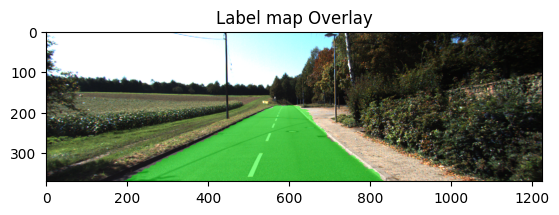

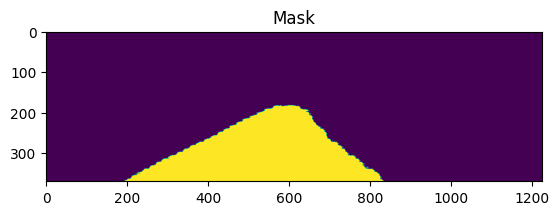

In [20]:
from matplotlib import pyplot as plt 


# show image using matplotlib

img = PIL.Image.open('./output/overlay_epoch1.png')
mask = PIL.Image.open('./output/mask_epoch1.png')
plt.imshow(img), plt.title('Label map Overlay');
plt.figure(), plt.imshow(mask), plt.title('Mask');

# Load the trained model and test

In [21]:
# Initialize the model
num_classes = 2
net = UNet(num_classes=num_classes)

# Do not use the trained model..
    
device = "cuda" # cuda  / cuda:0  / ...
net = net.to(device)

#validation
net.eval()

val_loss = 0

for batch_idx, (data, target) in enumerate(val_loader):
    # TODO
    # load data
    data, target = data.to(device), target.to(device)
    # forward
    score = net(data)

    loss = criterion(score, target)
    val_loss += loss.item() / len(data)

val_loss /= len(val_loader)
print ('val loss : %f'%val_loss)

#visualization
img = PIL.Image.open('./data/Kitti/data_road/testing/image_2/um_000081.png')
visualization(net, img, 999, device)

/home/piai/anaconda3/envs/cv_2025/lib/python3.8/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/piai/anaconda3/envs/cv_2025/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


val loss : 0.847222


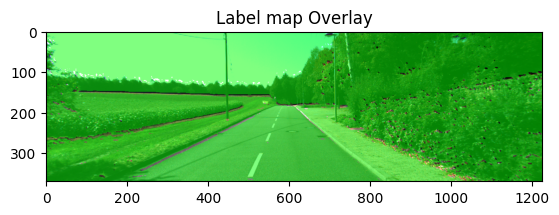

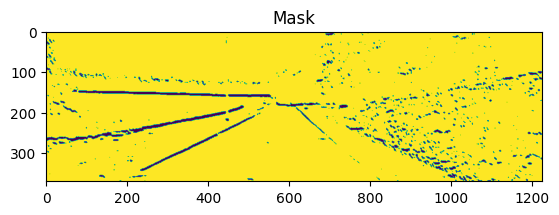

In [22]:
from matplotlib import pyplot as plt 


# show image using matplotlib

img = PIL.Image.open('./output/overlay_epoch1000.png')
mask = PIL.Image.open('./output/mask_epoch1000.png')
plt.imshow(img), plt.title('Label map Overlay');
plt.figure(), plt.imshow(mask), plt.title('Mask');

In [23]:
device = "cpu" # cuda  / cuda:0  / ...

net = UNet(2)
    
net = net.to(device)

net.load_state_dict(torch.load('trained_model.pkl'))

# validation
net.eval()

val_loss = 0

for batch_idx, (data, target) in enumerate(val_loader):
    # TODO
    # load data
    data, target = data.to(device), target.to(device)
    # forward
    score = net(data)

    loss = criterion(score, target)
    val_loss += loss.item() / len(data)

val_loss /= len(val_loader)
print ('val loss : %f'%val_loss)

#visualization
img = PIL.Image.open('./data/Kitti/data_road/testing/image_2/um_000081.png')
visualization(net, img, 999, device)

val loss : 0.215309


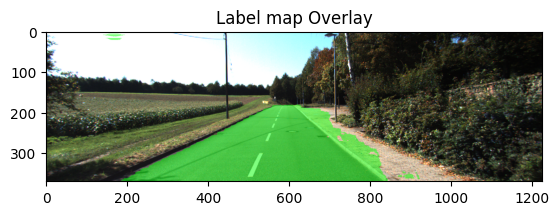

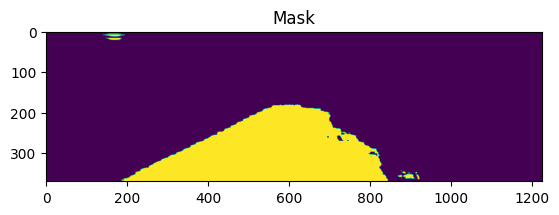

In [24]:
from matplotlib import pyplot as plt 


# show image using matplotlib

img = PIL.Image.open('./output/overlay_epoch1000.png')
mask = PIL.Image.open('./output/mask_epoch1000.png')
plt.imshow(img), plt.title('Label map Overlay');
plt.figure(), plt.imshow(mask), plt.title('Mask');

# Optional homework
## Improving the segmentation model

> 모델의 성능을 개선하는 방법은 다양합니다. 모델의 parameter 수를 늘리는 방법도 있고, optimizer를 변경하거나 learning rate, batch size를 변경하는 방법도 있습니다. 그리고 loss function을 변경하는 방법도 있습니다.
> 혹은 다수의 데이터로부터 Classification task에 미리 학습된 모델을 사용해 transfer learning을 수행할 수도 있습니다.